In [1]:
# ==================================================
# CELL 1: Import Libraries and Load Dataset
# ==================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)

print("="*70)
print("🎯 NOTEBOOK 2: CREATE TARGET LABELS FOR DISPUTE RESOLUTION")
print("="*70)

# Load the dataset
data_path = '../data/raw/complaints.csv'
print("\n🔄 Loading dataset...")
df = pd.read_csv(data_path, low_memory=False)

print(f"✅ Dataset loaded: {df.shape[0]:,} rows × {df.shape[1]} columns")
print("="*70)

🎯 NOTEBOOK 2: CREATE TARGET LABELS FOR DISPUTE RESOLUTION

🔄 Loading dataset...
✅ Dataset loaded: 777,959 rows × 18 columns


In [2]:
# ==================================================
# CELL 2: Find the Company Response/Resolution Column
# ==================================================

print("🔍 SEARCHING FOR RESOLUTION COLUMN...")
print("="*70)

# Look for columns with 'response' or 'resolution' in the name
response_cols = [col for col in df.columns if 'response' in col.lower() 
                 or 'resolution' in col.lower() 
                 or 'company' in col.lower()]

print(f"📌 Found {len(response_cols)} potential resolution column(s):\n")

for col in response_cols:
    print(f"Column: '{col}'")
    print(f"Unique values: {df[col].nunique()}")
    print(f"Missing values: {df[col].isnull().sum():,} ({df[col].isnull().sum()/len(df)*100:.2f}%)")
    print("\n" + "-"*70)

# Let's examine the main resolution column
# The CFPB dataset usually has "Company response to consumer"
if 'Company response to consumer' in df.columns:
    resolution_col = 'Company response to consumer'
    print(f"\n✅ MAIN RESOLUTION COLUMN IDENTIFIED: '{resolution_col}'")
else:
    # Find the most likely column
    resolution_col = response_cols[0] if response_cols else None
    print(f"\n✅ Using column: '{resolution_col}'")

print("="*70)

🔍 SEARCHING FOR RESOLUTION COLUMN...
📌 Found 5 potential resolution column(s):

Column: 'Company public response'
Unique values: 10
Missing values: 580,075 (74.56%)

----------------------------------------------------------------------
Column: 'Company'
Unique values: 4224
Missing values: 0 (0.00%)

----------------------------------------------------------------------
Column: 'Date sent to company'
Unique values: 1944
Missing values: 0 (0.00%)

----------------------------------------------------------------------
Column: 'Company response to consumer'
Unique values: 8
Missing values: 0 (0.00%)

----------------------------------------------------------------------
Column: 'Timely response?'
Unique values: 2
Missing values: 0 (0.00%)

----------------------------------------------------------------------

✅ MAIN RESOLUTION COLUMN IDENTIFIED: 'Company response to consumer'


In [3]:
# ==================================================
# CELL 3: Analyze All Unique Resolution Outcomes
# ==================================================

print("📊 ALL UNIQUE RESOLUTION OUTCOMES:")
print("="*70)

if resolution_col:
    # Get value counts
    resolution_counts = df[resolution_col].value_counts()
    resolution_percent = (df[resolution_col].value_counts(normalize=True) * 100)
    
    # Create summary dataframe
    resolution_summary = pd.DataFrame({
        'Resolution_Outcome': resolution_counts.index,
        'Count': resolution_counts.values,
        'Percentage': resolution_percent.values
    })
    
    print(f"\nTotal unique outcomes: {df[resolution_col].nunique()}\n")
    print(resolution_summary.to_string(index=False))
    
    print("\n" + "="*70)
    
    # Store for later use
    unique_resolutions = df[resolution_col].unique()
    print(f"\n📋 LIST OF ALL UNIQUE RESOLUTIONS:")
    print("-"*70)
    for idx, res in enumerate(unique_resolutions, 1):
        if pd.notna(res):  # Skip NaN values
            print(f"{idx}. {res}")
    
    print("\n" + "="*70)
else:
    print("❌ No resolution column found! Please check column names.")

📊 ALL UNIQUE RESOLUTION OUTCOMES:

Total unique outcomes: 8

             Resolution_Outcome  Count  Percentage
        Closed with explanation 581562   74.754839
Closed with non-monetary relief  95957   12.334455
    Closed with monetary relief  51581    6.630298
          Closed without relief  17868    2.296779
                         Closed  17611    2.263744
             Closed with relief   5304    0.681784
                    In progress   4382    0.563269
              Untimely response   3694    0.474832


📋 LIST OF ALL UNIQUE RESOLUTIONS:
----------------------------------------------------------------------
1. Closed with non-monetary relief
2. Closed with explanation
3. In progress
4. Closed with monetary relief
5. Untimely response
6. Closed
7. Closed without relief
8. Closed with relief



In [4]:
# ==================================================
# CELL 4: Map Resolution Outcomes to Target Labels
# ==================================================

print("🎯 CREATING DISPUTE RESOLUTION MAPPING")
print("="*70)

# Define the mapping logic
# favour_customer: Customer got what they wanted (monetary relief, issue resolved in their favor)
# favor_seller: Company defended their position (closed with explanation, no relief)
# split_payment: Partial resolution (non-monetary relief, compromise)

resolution_mapping = {
    # CUSTOMER WINS (favour_customer)
    'Closed with monetary relief': 'favour_customer',
    'Closed with relief': 'favour_customer',
    
    # SELLER/COMPANY WINS (favor_seller)
    'Closed with explanation': 'favor_seller',
    'Closed without relief': 'favor_seller',
    'Closed': 'favor_seller',
    
    # COMPROMISE/SPLIT (split_payment)
    'Closed with non-monetary relief': 'split_payment',
    
    # INCOMPLETE/IN PROGRESS - we'll handle these separately
    'In progress': 'incomplete',
    'Untimely response': 'incomplete',
}

print("📋 MAPPING LOGIC:\n")
print("=" * 70)
print("\n🟢 FAVOUR_CUSTOMER (Buyer Wins):")
print("   • Closed with monetary relief")
print("   • Closed with relief")
print("   → Customer received money or full resolution")

print("\n🔴 FAVOR_SELLER (Seller/Company Wins):")
print("   • Closed with explanation")
print("   • Closed without relief")
print("   • Closed")
print("   → Company defended position, no relief given")

print("\n🟡 SPLIT_PAYMENT (Compromise):")
print("   • Closed with non-monetary relief")
print("   → Partial resolution, non-monetary compensation")

print("\n⚪ INCOMPLETE (Will be removed):")
print("   • In progress")
print("   • Untimely response")
print("   → Cannot determine outcome yet")

print("\n" + "="*70)

🎯 CREATING DISPUTE RESOLUTION MAPPING
📋 MAPPING LOGIC:


🟢 FAVOUR_CUSTOMER (Buyer Wins):
   • Closed with monetary relief
   • Closed with relief
   → Customer received money or full resolution

🔴 FAVOR_SELLER (Seller/Company Wins):
   • Closed with explanation
   • Closed without relief
   • Closed
   → Company defended position, no relief given

🟡 SPLIT_PAYMENT (Compromise):
   • Closed with non-monetary relief
   → Partial resolution, non-monetary compensation

⚪ INCOMPLETE (Will be removed):
   • In progress
   • Untimely response
   → Cannot determine outcome yet



In [5]:
# ==================================================
# CELL 5: Create the Target Label Column
# ==================================================

print("🔄 APPLYING MAPPING TO CREATE TARGET LABELS...")
print("="*70)

# Create a copy of the dataframe for safety
df_labeled = df.copy()

# Apply the mapping
df_labeled['dispute_resolution'] = df_labeled[resolution_col].map(resolution_mapping)

# Check how many records we mapped successfully
mapped_count = df_labeled['dispute_resolution'].notna().sum()
unmapped_count = df_labeled['dispute_resolution'].isna().sum()

print(f"✅ Mapping Complete!")
print(f"\n📊 Mapping Results:")
print(f"   • Successfully mapped: {mapped_count:,} records ({mapped_count/len(df_labeled)*100:.2f}%)")
print(f"   • Unmapped/Missing: {unmapped_count:,} records ({unmapped_count/len(df_labeled)*100:.2f}%)")

print("\n" + "="*70)

# Show distribution of target labels
print("\n📊 DISTRIBUTION OF TARGET LABELS:")
print("="*70)

target_counts = df_labeled['dispute_resolution'].value_counts()
target_percent = (df_labeled['dispute_resolution'].value_counts(normalize=True) * 100)

target_summary = pd.DataFrame({
    'Dispute_Outcome': target_counts.index,
    'Count': target_counts.values,
    'Percentage': target_percent.values
})

print(target_summary.to_string(index=False))
print("\n" + "="*70)

🔄 APPLYING MAPPING TO CREATE TARGET LABELS...
✅ Mapping Complete!

📊 Mapping Results:
   • Successfully mapped: 777,959 records (100.00%)
   • Unmapped/Missing: 0 records (0.00%)


📊 DISTRIBUTION OF TARGET LABELS:
Dispute_Outcome  Count  Percentage
   favor_seller 617041   79.315362
  split_payment  95957   12.334455
favour_customer  56885    7.312082
     incomplete   8076    1.038101



📊 CREATING VISUALIZATIONS...


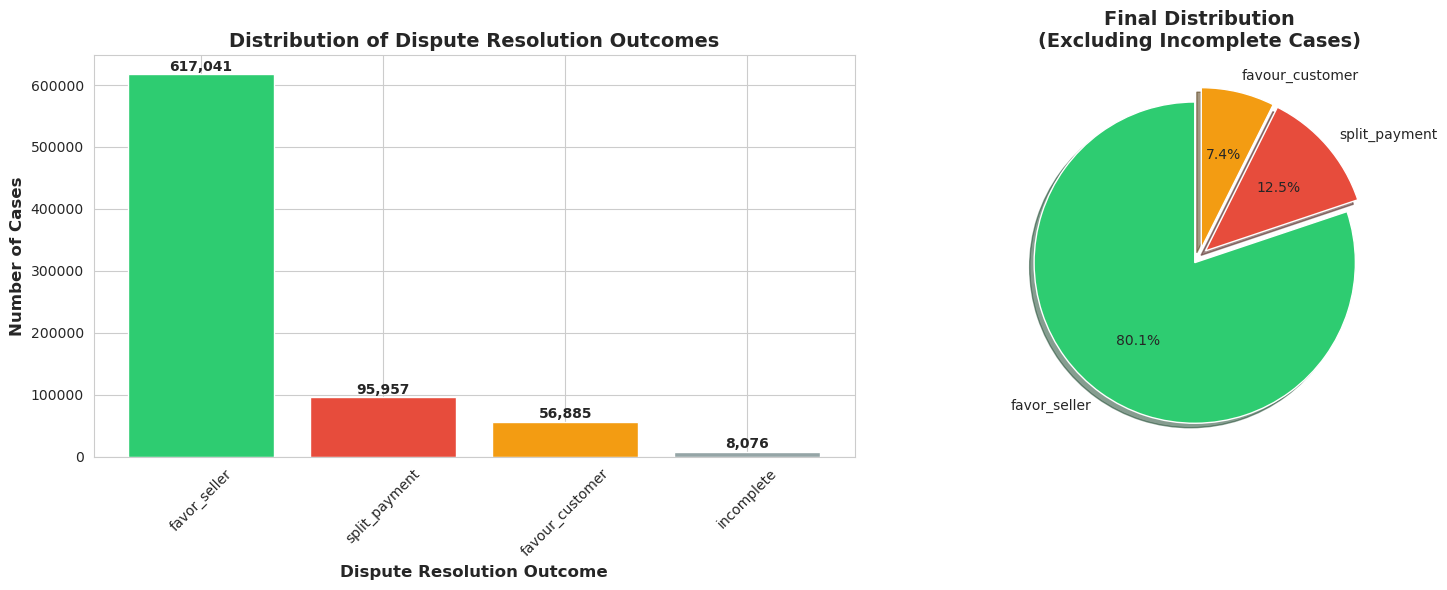

✅ Visualizations created successfully!


In [6]:
# ==================================================
# CELL 6: Visualize Target Label Distribution
# ==================================================

print("📊 CREATING VISUALIZATIONS...")
print("="*70)

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Count plot
target_counts_clean = df_labeled['dispute_resolution'].value_counts()

# Plot 1: Bar chart
axes[0].bar(target_counts_clean.index, target_counts_clean.values, 
            color=['#2ecc71', '#e74c3c', '#f39c12', '#95a5a6'])
axes[0].set_xlabel('Dispute Resolution Outcome', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Cases', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution of Dispute Resolution Outcomes', fontsize=14, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)

# Add value labels on bars
for i, (label, value) in enumerate(zip(target_counts_clean.index, target_counts_clean.values)):
    axes[0].text(i, value + max(target_counts_clean.values)*0.01, 
                f'{value:,}', ha='center', fontsize=10, fontweight='bold')

# Plot 2: Pie chart (excluding incomplete)
target_counts_final = df_labeled[df_labeled['dispute_resolution'] != 'incomplete']['dispute_resolution'].value_counts()
colors = ['#2ecc71', '#e74c3c', '#f39c12']
explode = (0.05, 0.05, 0.05)

axes[1].pie(target_counts_final.values, labels=target_counts_final.index, 
           autopct='%1.1f%%', colors=colors, explode=explode,
           shadow=True, startangle=90)
axes[1].set_title('Final Distribution\n(Excluding Incomplete Cases)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("✅ Visualizations created successfully!")
print("="*70)

In [7]:
# ==================================================
# CELL 7: Remove Incomplete Cases
# ==================================================

print("🗑️ REMOVING INCOMPLETE CASES...")
print("="*70)

# Store original size
original_size = len(df_labeled)

# Remove incomplete cases
df_final = df_labeled[df_labeled['dispute_resolution'] != 'incomplete'].copy()

# Also remove any NaN in dispute_resolution
df_final = df_final[df_final['dispute_resolution'].notna()].copy()

# Calculate removed
removed_count = original_size - len(df_final)

print(f"📊 Cleaning Results:")
print(f"   • Original dataset: {original_size:,} records")
print(f"   • Removed incomplete: {removed_count:,} records ({removed_count/original_size*100:.2f}%)")
print(f"   • Final dataset: {len(df_final):,} records ({len(df_final)/original_size*100:.2f}%)")

print("\n" + "="*70)

# Show final distribution
print("\n✅ FINAL TARGET LABEL DISTRIBUTION:")
print("="*70)

final_counts = df_final['dispute_resolution'].value_counts()
final_percent = (df_final['dispute_resolution'].value_counts(normalize=True) * 100)

final_summary = pd.DataFrame({
    'Dispute_Outcome': final_counts.index,
    'Count': final_counts.values,
    'Percentage': final_percent.values
})

print(final_summary.to_string(index=False))
print("\n" + "="*70)

🗑️ REMOVING INCOMPLETE CASES...
📊 Cleaning Results:
   • Original dataset: 777,959 records
   • Removed incomplete: 8,076 records (1.04%)
   • Final dataset: 769,883 records (98.96%)


✅ FINAL TARGET LABEL DISTRIBUTION:
Dispute_Outcome  Count  Percentage
   favor_seller 617041   80.147373
  split_payment  95957   12.463842
favour_customer  56885    7.388785



In [8]:
# ==================================================
# CELL 8: Analyze Class Balance
# ==================================================

print("⚖️ CHECKING CLASS BALANCE...")
print("="*70)

# Calculate class distribution
class_distribution = df_final['dispute_resolution'].value_counts(normalize=True) * 100

print("\n📊 Class Distribution:")
for label, percentage in class_distribution.items():
    print(f"   • {label}: {percentage:.2f}%")

# Check if classes are imbalanced
max_class_pct = class_distribution.max()
min_class_pct = class_distribution.min()
imbalance_ratio = max_class_pct / min_class_pct

print(f"\n⚖️ Balance Analysis:")
print(f"   • Largest class: {max_class_pct:.2f}%")
print(f"   • Smallest class: {min_class_pct:.2f}%")
print(f"   • Imbalance ratio: {imbalance_ratio:.2f}x")

if imbalance_ratio > 3:
    print(f"\n⚠️ WARNING: Classes are HIGHLY IMBALANCED!")
    print(f"   → We will need to use techniques like:")
    print(f"      • Class weights in model training")
    print(f"      • SMOTE (Synthetic Minority Over-sampling)")
    print(f"      • Stratified sampling")
elif imbalance_ratio > 2:
    print(f"\n⚠️ Classes are MODERATELY IMBALANCED")
    print(f"   → We should consider using class weights")
else:
    print(f"\n✅ Classes are RELATIVELY BALANCED")
    print(f"   → No special balancing needed")

print("\n" + "="*70)

⚖️ CHECKING CLASS BALANCE...

📊 Class Distribution:
   • favor_seller: 80.15%
   • split_payment: 12.46%
   • favour_customer: 7.39%

⚖️ Balance Analysis:
   • Largest class: 80.15%
   • Smallest class: 7.39%
   • Imbalance ratio: 10.85x

⚠️ WARNING: Classes are HIGHLY IMBALANCED!
   → We will need to use techniques like:
      • Class weights in model training
      • SMOTE (Synthetic Minority Over-sampling)
      • Stratified sampling



In [9]:
# ==================================================
# CELL 9: Select Key Columns for Dispute Model
# ==================================================

print("📋 SELECTING IMPORTANT COLUMNS FOR MODEL...")
print("="*70)

# Display all available columns
print("\n📝 All available columns:")
for idx, col in enumerate(df_final.columns, 1):
    print(f"{idx}. {col}")

print("\n" + "="*70)

# Define columns we want to keep for modeling
# Adjust based on what's actually in your dataset!
important_columns = []

# Must have: target label
important_columns.append('dispute_resolution')

# Common useful columns in CFPB dataset
potential_columns = [
    'Product',
    'Sub-product', 
    'Issue',
    'Sub-issue',
    'Consumer complaint narrative',
    'Company',
    'State',
    'ZIP code',
    'Tags',
    'Consumer consent provided?',
    'Submitted via',
    'Date received',
    'Date sent to company',
    'Company response to consumer',  # Original resolution
    'Timely response?',
    'Consumer disputed?'
]

# Add columns that exist in the dataframe
for col in potential_columns:
    if col in df_final.columns:
        important_columns.append(col)

print(f"\n✅ Selected {len(important_columns)} important columns:\n")
for idx, col in enumerate(important_columns, 1):
    non_null = df_final[col].notna().sum()
    completeness = (non_null / len(df_final)) * 100
    print(f"{idx}. {col}")
    print(f"   → {non_null:,} non-null values ({completeness:.1f}% complete)")

print("\n" + "="*70)

# Create final dataframe with selected columns
df_model = df_final[important_columns].copy()

print(f"\n📊 MODEL DATASET:")
print(f"   • Shape: {df_model.shape[0]:,} rows × {df_model.shape[1]} columns")
print(f"   • Memory: {df_model.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\n" + "="*70)

📋 SELECTING IMPORTANT COLUMNS FOR MODEL...

📝 All available columns:
1. Date received
2. Product
3. Sub-product
4. Issue
5. Sub-issue
6. Consumer complaint narrative
7. Company public response
8. Company
9. State
10. ZIP code
11. Tags
12. Consumer consent provided?
13. Submitted via
14. Date sent to company
15. Company response to consumer
16. Timely response?
17. Consumer disputed?
18. Complaint ID
19. dispute_resolution


✅ Selected 17 important columns:

1. dispute_resolution
   → 769,883 non-null values (100.0% complete)
2. Product
   → 769,883 non-null values (100.0% complete)
3. Sub-product
   → 535,892 non-null values (69.6% complete)
4. Issue
   → 769,883 non-null values (100.0% complete)
5. Sub-issue
   → 315,492 non-null values (41.0% complete)
6. Consumer complaint narrative
   → 156,563 non-null values (20.3% complete)
7. Company
   → 769,883 non-null values (100.0% complete)
8. State
   → 764,092 non-null values (99.2% complete)
9. ZIP code
   → 764,054 non-null values (99

In [10]:
# ==================================================
# CELL 10: Save the Processed Dataset
# ==================================================

print("💾 SAVING PROCESSED DATASET...")
print("="*70)

# Define output path
output_path = '../data/processed/complaints_labeled.csv'

# Save the dataframe
df_model.to_csv(output_path, index=False)

# Verify file was saved
import os
file_size = os.path.getsize(output_path) / (1024**2)  # Size in MB

print(f"✅ Dataset saved successfully!")
print(f"\n📁 File Details:")
print(f"   • Location: {output_path}")
print(f"   • File size: {file_size:.2f} MB")
print(f"   • Records: {len(df_model):,}")
print(f"   • Columns: {df_model.shape[1]}")

print("\n" + "="*70)

💾 SAVING PROCESSED DATASET...
✅ Dataset saved successfully!

📁 File Details:
   • Location: ../data/processed/complaints_labeled.csv
   • File size: 300.71 MB
   • Records: 769,883
   • Columns: 17



In [11]:
# ==================================================
# CELL 11: Complete Summary
# ==================================================

print("="*70)
print(" ✅ TARGET LABEL CREATION COMPLETE!")
print("="*70)

print("\n📊 SUMMARY OF WHAT WE ACCOMPLISHED:\n")

print("1. ✅ Identified resolution column")
print(f"   → Used: '{resolution_col}'")

print("\n2. ✅ Mapped outcomes to 3 dispute labels:")
print("   → favour_customer: Customer wins")
print("   → favor_seller: Seller/Company wins")
print("   → split_payment: Compromise/partial resolution")

print(f"\n3. ✅ Cleaned dataset:")
print(f"   → Original: {original_size:,} records")
print(f"   → Final: {len(df_model):,} records")
print(f"   → Removed: {original_size - len(df_model):,} incomplete cases")

print(f"\n4. ✅ Final distribution:")
for label, count in df_model['dispute_resolution'].value_counts().items():
    percentage = (count / len(df_model)) * 100
    print(f"   → {label}: {count:,} ({percentage:.2f}%)")

print(f"\n5. ✅ Selected {df_model.shape[1]} important columns for modeling")

print(f"\n6. ✅ Saved processed data:")
print(f"   → Location: ../data/processed/complaints_labeled.csv")

print("\n" + "="*70)
print("🎯 NEXT STEP: Data Cleaning & Text Preprocessing")
print("="*70)

print("\n💡 In the next notebook, we will:")
print("   1. Clean the complaint narrative text")
print("   2. Handle missing values")
print("   3. Prepare text for machine learning")
print("   4. Extract features from text data")

print("\n" + "="*70)

 ✅ TARGET LABEL CREATION COMPLETE!

📊 SUMMARY OF WHAT WE ACCOMPLISHED:

1. ✅ Identified resolution column
   → Used: 'Company response to consumer'

2. ✅ Mapped outcomes to 3 dispute labels:
   → favour_customer: Customer wins
   → favor_seller: Seller/Company wins
   → split_payment: Compromise/partial resolution

3. ✅ Cleaned dataset:
   → Original: 777,959 records
   → Final: 769,883 records
   → Removed: 8,076 incomplete cases

4. ✅ Final distribution:
   → favor_seller: 617,041 (80.15%)
   → split_payment: 95,957 (12.46%)
   → favour_customer: 56,885 (7.39%)

5. ✅ Selected 17 important columns for modeling

6. ✅ Saved processed data:
   → Location: ../data/processed/complaints_labeled.csv

🎯 NEXT STEP: Data Cleaning & Text Preprocessing

💡 In the next notebook, we will:
   1. Clean the complaint narrative text
   2. Handle missing values
   3. Prepare text for machine learning
   4. Extract features from text data

